In [16]:
import numpy as np
import matplotlib.pyplot as plt


In [17]:
# Полином Чебышева первого рода степени degree от аргумента x 
# По определению из формулировки лабораторной
def cheb(x, degree):
    if degree == 0:
        return 1
    elif degree == 1:
        return x
    return 2 * x * cheb(x, degree - 1) - cheb(x, degree - 2)

In [18]:
# Функции аппроксимации (иными словами - решение СЛАУ Ac = y)
#
# Обе функции имеют одинаковый набор аргументов
# 1) A - матрица значений cheb, размерности, M строк, N+1 столбец
# 2) N - порядок решения, его также можно вычислить из размера A
# 3) X - значения x из экспериментальны данных
# 3) y - значения y из экспериментальны данных
#
# Функции возвращают 
# 1) Матрицу, которая будет использоваться в отчете
# 2) Вектор аппроксисимрованного y, вычисленного на основе вектора c (решения СЛАУ)

# Апроксимация методом решения НУ
def calc_ne_approx(A, N, X, y):
    At = np.transpose(A)
    
    # По руководству из описания лабы 
    # At*A*c = At*y => c = (At*A)^-1 * At*y
    c = np.linalg.pinv(At.dot(A)).dot(At).dot(y) 
    
    # Для отчета используется матрица At*A
    # Расчет аппрокс y: для каждого x вычисляется сумма значений cheb(degree, x) * с[degree], degree от 0 до N
    return At.dot(A), [sum([c[degree] * cheb(x, degree) for degree in range(N + 1)]) for x in X]

# Аппроксимация методом вращений Гивенса
def calc_qr_approx(A, N, X, y):
    # Обязательно нужно скопировать y, т.к. в коде этот вектор модифицируется
    y = np.copy(y)
    
    # Для экономиии времени и ресурсов используется упрощенный метод вращений
    # Применение матрицы вращения Qij модифицирует только строки c индексами i и j
    # При этом в отчете требуется только приводить Q*R,достаточно просто применять вращения методом 
    # выше, модифицируя исходную матрицу А, при этом не создавая дополнительных матриц
    for column in range(A.shape[1]):
        for line in range(column + 1, A.shape[0]):
            # Расчет коээфициента поворота
            # Формула взята с https://studfile.net/preview/1544152/page:6/
            c = A[column, column] / np.sqrt(A[column, column] ** 2 + A[line, column] ** 2)
            s = -A[line, column] / np.sqrt(A[column, column] ** 2 + A[line, column] ** 2)
            
            # Модификация строк
            # Сначала нужно скопировать данные и применить вращение, а потом уже внести изменения в A
            A_column = c * A[column, :] - s * A[line, :]
            A_line = s * A[column, :] + c * A[line, :]
            A[column, :] = A_column
            A[line, :] = A_line

            # Вращение также влияет на вектор y (мадификация происходит также в строках)
            y_column = c * y[column] - s * y[line]
            y_line = s * y[column] + c * y[line]
            y[column] = y_column
            y[line] = y_line
    
    # Имеем A - верхнетреугольную матрицу (она равна QR)
    # Путем обратног хода Гаусса решаем СЛАУ Ac = b
    c = np.zeros(N + 1)
    c[N] = y[N] / A[N, N]
    for i in range(N - 1, -1, -1):
        c[i] = (y[i] - np.sum(A[i][i + 1:N + 1] * c[i + 1:N + 1])) / A[i][i]
        
    # Возращаем QR и аппрокс значения y    
    return A, [sum([c[degree] * cheb(x, degree) for degree in range(N + 1)]) for x in X]

In [19]:
# Величина среднеквадратичного отклонения функции (по формуле из задачи)
# y - экспериментальные значения, y_approx - аппроксимированные
def SME(y, y_approx):
    return np.sqrt(sum(np.square(np.abs(y - y_approx))) / len(y)) / max(y_approx)

# Величина обусловленности матрицы (используется в отчетах)
def mu(A):
    return np.linalg.cond(A)

# Запуск функции аппрокс approx_func (под названием name) для порядков от 1 до 10 
# Возвращает характеристики решения задачи аппроксимации (SME и mu)
def run_approx(name, approx_func):
    # res накапливает результаты запусков для разных порядков решения
    res = []
    
    # Строим график экспериментальных данных
    plt.plot(X, y, label='y')
    
    for N in range(1, 11):
        # Подготавливаем для A СЛАУ Ac = y
        A = np.asarray([[cheb(x, degree) for degree in range(N + 1)] for x in X])
        
        # Решаем СЛАУ, получаем матрицу AtA или QR (в зависимости от метода) и аппрокс y
        A, y_approx = approx_func(A, N, X, y)
        
        # Вычисляем характеристики решения
        sme = SME(y, y_approx)
        mua = mu(A)
        
        # Выводи характеристики, добавляем график решения 
        print(f'{name}[{N}] SME={sme}, mu={mua}')
        plt.plot(X, y_approx, label='y_pred' + str(N))
        
        # Добавляем в res характеристики решения
        res.append((sme, mua))
        
    # Строим график    
    plt.legend()
    plt.title(name)
    plt.show()
    
    return res


In [20]:
# Загрузка данных
with open('experiment_3.txt') as in_file:
    in_data = [(float(l), float(r))
               for (l, r) in [line.split(' ')
                              for line in in_file.readlines()]]
in_data = np.asarray(in_data)
X = in_data[:, 0]
y = in_data[:, 1]

NE[1] SME=0.006505310754408599, mu=342.245741196976
NE[2] SME=0.002918244098222698, mu=147827.9745108433
NE[3] SME=0.000669599840015131, mu=84896289.42889959
NE[4] SME=0.000663996751233451, mu=40179947350.68278
NE[5] SME=0.0006282723941056422, mu=23710322725736.152
NE[6] SME=0.0006307203868201959, mu=8212469500004831.0
NE[7] SME=0.0006237531534974065, mu=1.34199196231216e+18
NE[8] SME=0.0006314236339124851, mu=4.040561672265645e+17
NE[9] SME=0.0005290420295349949, mu=5.248746957833054e+17
NE[10] SME=0.0004837742375746855, mu=4.94196842099797e+17
QR[1] SME=0.006505310754408584, mu=18.49988489685749
QR[2] SME=0.002918244098221485, mu=384.4840367469122
QR[3] SME=0.0006695998399905671, mu=9213.918243020064
QR[4] SME=0.0006639967858421485, mu=200449.83300659785
QR[5] SME=0.0006250458928498023, mu=4869671.578549766
QR[6] SME=0.0004826073242443699, mu=107137708.08457866
QR[7] SME=0.0004641088100133365, mu=2602065056.431289
QR[8] SME=0.00038424870769766345, mu=57732333510.30003
QR[9] SME=0.000

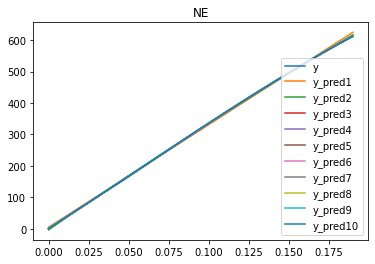

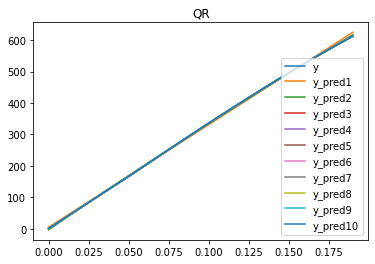

In [21]:
# Запуск алгоритмов для разного порядка аппроксимации N
res_ne = run_approx('NE', calc_ne_approx)
res_qr = run_approx('QR', calc_qr_approx)

# Вывод таблицы результатов
print('\t'.join(['N', 'mu(AtA)(NE)', 'SME(NE)', 'mu(A)(QR)', 'SME(QR)']))
for i in range(10):
    line = '\t'.join(
        map(str, [i + 1, res_ne[i][0], res_ne[i][1], res_qr[i][0], res_qr[i][0]]))
    print(line)
